# ライブラリ

In [47]:
!pip install pulp
import pulp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# 4.3 データ理解

## データの確認

### 会員データの確認

In [2]:
# データ読み込み
cust_df = pd.read_csv("https://raw.githubusercontent.com/ohmsha/PyOptBook/main/4.coupon/customers.csv")
cust_df

,customer_id,age_cat,freq_cat
0,1,age20~34,freq2
1,2,age35~49,freq0
2,3,age35~49,freq0
3,4,age~19,freq0
4,5,age35~49,freq0
...,...,...,...
4995,4996,age50~,freq0
4996,4997,age50~,freq0
4997,4998,age35~49,freq1
4998,4999,age50~,freq1


In [3]:
# データの型
cust_df.dtypes

customer_id     int64
age_cat        object
freq_cat       object
dtype: object

Text(0, 0.5, 'num')

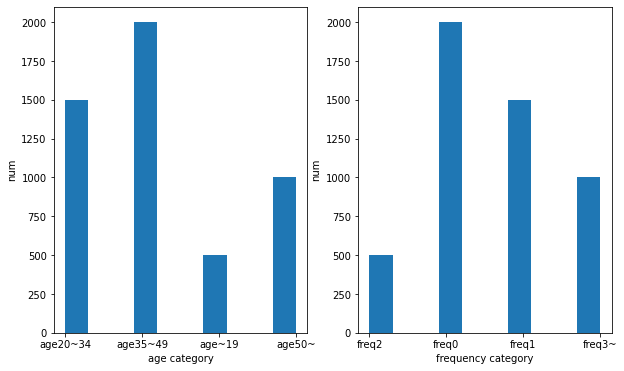

In [4]:
# 年齢区分および昨年度来店回数区分の分布
fig, [ax1, ax2] = plt.subplots(figsize = (10, 6), nrows = 1, ncols = 2)
ax1.hist(cust_df["age_cat"])
ax1.set_xlabel("age category")
ax1.set_ylabel("num")
ax2.hist(cust_df["freq_cat"])
ax2.set_xlabel("frequency category")
ax2.set_ylabel("num")

In [5]:
# 年齢および昨年度来店回数区分別の人数
cust_pivot_df = pd.pivot_table(data = cust_df, values = "customer_id", columns = "freq_cat", index = "age_cat", aggfunc = "count")
cust_pivot_df = cust_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
cust_pivot_df

freq_cat,freq0,freq1,freq2,freq3~
age_cat,,,,
age~19,200,150,50,100
age20~34,600,450,150,300
age35~49,800,600,200,400
age50~,400,300,100,200


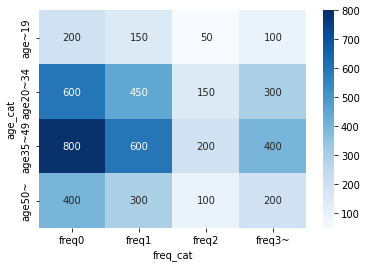

In [6]:
# 上記をヒートマップで可視化
sns.heatmap(cust_pivot_df, annot = True, fmt = "d", cmap = "Blues")

### 来店率データの確認

In [7]:
# データ読み込み
prob_df = pd.read_csv("https://raw.githubusercontent.com/ohmsha/PyOptBook/main/4.coupon/visit_probability.csv")
prob_df

,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,age~19,freq0,1,0.07,0.12,0.29
1,age~19,freq1,2,0.21,0.30,0.58
2,age~19,freq2,3,0.28,0.39,0.74
3,age~19,freq3~,4,0.35,0.45,0.77
4,age20~34,freq0,5,0.11,0.17,0.37
5,age20~34,freq1,6,0.32,0.43,0.72
6,age20~34,freq2,7,0.42,0.55,0.93
7,age20~34,freq3~,8,0.52,0.63,0.94
8,age35~49,freq0,9,0.08,0.14,0.33
9,age35~49,freq1,10,0.25,0.35,0.67


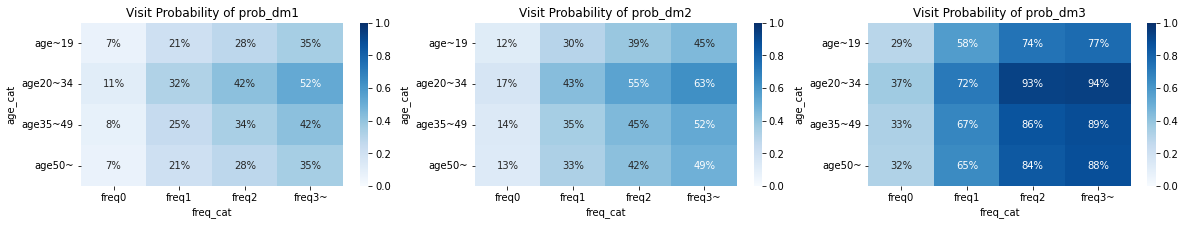

In [8]:
# セグメント別来店率の可視化
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 3))
for i, ptn in enumerate(["prob_dm1", "prob_dm2", "prob_dm3"]):
  prob_pivot_df = pd.pivot_table(data = prob_df, values = ptn, columns = "freq_cat", index = "age_cat")
  prob_pivot_df = prob_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
  sns.heatmap(prob_pivot_df, vmin = 0, vmax = 1, annot = True, fmt = ".0%", cmap = "Blues", ax = ax[i])
  ax[i].set_title(f"Visit Probability of {ptn}")

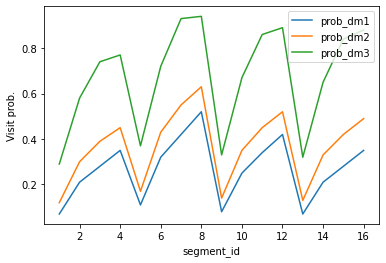

In [9]:
# 折れ線グラフ
plt.plot(prob_df["segment_id"], prob_df["prob_dm1"], label = "prob_dm1")
plt.plot(prob_df["segment_id"], prob_df["prob_dm2"], label = "prob_dm2")
plt.plot(prob_df["segment_id"], prob_df["prob_dm3"], label = "prob_dm3")
plt.xlabel("segment_id")
plt.ylabel("Visit prob.")
plt.legend(loc = "best")

# 4.4 数理モデリングと実装

## モデリング１：会員個別送付モデル

- 収束せず

In [10]:
# インスタンス生成
problem = pulp.LpProblem(name = "DiscountCouponProblem1", sense = pulp.LpMaximize)

In [13]:
# 会員IDのリスト
I = cust_df["customer_id"].to_list()

# ダイレクトメールのパターンのリスト
M = [1, 2, 3]

In [14]:
# 要件１：各会員に対してどのパターンのダイレクトメールを送付するかを決定

# 決定変数を定義
xim = {}
for i in I:
  for m in M:
    xim[i, m] = pulp.LpVariable(name = f"xim({i}, {m})", cat = "Binary")

# 決定変数の数
len(xim)

15000

In [24]:
# 要件２：各会員に対して送付するダイレクトメールはいずれか１パターン
for i in I:
  problem += pulp.lpSum(xim[i, m] for m in M) == 1

In [25]:
# 会員データと来店率データを結合
keys = ["age_cat", "freq_cat"]
cust_prob_df = pd.merge(cust_df, prob_df, on = keys)
cust_prob_df.head()

,customer_id,age_cat,freq_cat,segment_id,prob_dm1,prob_dm2,prob_dm3
0,1,age20~34,freq2,7,0.42,0.55,0.93
1,199,age20~34,freq2,7,0.42,0.55,0.93
2,200,age20~34,freq2,7,0.42,0.55,0.93
3,255,age20~34,freq2,7,0.42,0.55,0.93
4,269,age20~34,freq2,7,0.42,0.55,0.93


In [28]:
# cust_prob_dfをwide型からlong型へ変換
cust_prob_ver_df = cust_prob_df.rename(columns = {"prob_dm1": 1, "prob_dm2": 2, "prob_dm3": 3}).melt(id_vars = ["customer_id"], value_vars = [1, 2, 3], var_name = "dm", value_name = "prob")
cust_prob_ver_df

,customer_id,dm,prob
0,1,1,0.42
1,199,1,0.42
2,200,1,0.42
3,255,1,0.42
4,269,1,0.42
...,...,...,...
14995,4474,3,0.74
14996,4596,3,0.74
14997,4720,3,0.74
14998,4910,3,0.74


In [33]:
# 辞書P_imを定義
Pim = cust_prob_ver_df.set_index(["customer_id", "dm"])["prob"].to_dict()

# 例．会員IDが１の会員にパターン１のダイレクトメールを送付したときの来店率
Pim[1, 1]

0.42

In [34]:
# 要件３：クーポン付与による来客増加数を最大化
problem += pulp.lpSum( (Pim[i, m] - Pim[i, 1]) * xim[i, m] for i in I for m in [2, 3] )

In [36]:
# 辞書Cmを定義
Cm = {1: 0, 2: 1000, 3: 2000}

In [37]:
# 要件４：顧客の消費する費用の期待値の合計は100万円以下
problem += pulp.lpSum( Cm[m] * Pim[i, m] * xim[i, m] for i in I for m in [2, 3] ) <= 1000000

In [40]:
# セグメントのリスト
S = prob_df["segment_id"].to_list()

# セグメント数
len(S)

16

In [42]:
# 各セグメントとそのセグメントに属する顧客数を対応させる辞書
Ns = cust_prob_df.groupby("segment_id")["customer_id"].count().to_dict()
Ns

{1: 200,
 2: 150,
 3: 50,
 4: 100,
 5: 600,
 6: 450,
 7: 150,
 8: 300,
 9: 800,
 10: 600,
 11: 200,
 12: 400,
 13: 400,
 14: 300,
 15: 100,
 16: 200}

In [45]:
# 会員IDと属するセグメントを対応させる辞書
Si = cust_prob_df.set_index("customer_id")["segment_id"].to_dict()

In [46]:
# 要件５：各パターンのダイレクトメールをそれぞれのセグメントに属する会員10%以上に送付
for s in S:
  for m in M:
    problem += pulp.lpSum( xim[i, m] for i in I if Si[i] == s ) >= 0.1 * Ns[s]

In [54]:
# 問題を解く（計算時間も計測）
#time_start = time.time()
#status = problem.solve()
#time_stop = time.time()

# 結果
#print(f"ステータス：{pulp.LpStatus[status]}")
#print(f"目的関数値：{pulp.value(problem.objective):.4}")
#print(f"計算時間：{(time_stop - time_start):.3}（秒）")

## モデリング２：セグメント送付モデル

In [49]:
# インスタンス生成
problem = pulp.LpProblem(name = "DiscountCouponProblem2", sense = pulp.LpMaximize)

In [51]:
# 要件１：各セグメントに対してそれぞれのパターンのダイレクトメールをどの程度送付するかを決定

# 決定変数を定義
xsm = {}
for s in S:
  for m in M:
    xsm[s, m] = pulp.LpVariable(name = f"xsm({s}, {m})", lowBound = 0, upBound = 1, cat = "Continuous")

# 決定変数の数
len(xsm)

48

In [53]:
# 要件２：各会員に対して送付するダイレクトメールはいずれか１パターン
for s in S:
  problem += pulp.lpSum( xsm[s, m] for m in M ) == 1

In [57]:
# prob_dfをwide型からlong型へ変換
prob_ver_df = prob_df.rename(columns = {"prob_dm1": 1, "prob_dm2": 2, "prob_dm3": 3}).melt(id_vars = ["segment_id"], value_vars = [1, 2, 3], var_name = "dm", value_name = "prob")
prob_ver_df.head()

,segment_id,dm,prob
0,1,1,0.07
1,2,1,0.21
2,3,1,0.28
3,4,1,0.35
4,5,1,0.11


In [59]:
# 辞書P_smを定義
Psm = prob_ver_df.set_index(["segment_id", "dm"])["prob"].to_dict()

In [60]:
# 要件３：クーポン付与による来客増加数を最大化
problem += pulp.lpSum( Ns[s] * (Psm[s, m] - Psm[s, 1]) * xsm[s, m] for s in S for m in [2, 3] )

In [61]:
# 要件４：会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum( Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3] ) <= 1000000

In [62]:
# 要件５：各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上送付
for s in S:
  for m in M:
    problem += xsm[s, m] >= 0.1

In [63]:
# 問題を解く（計算時間も計測）
time_start = time.time()
status = problem.solve()
time_stop = time.time()

# 結果
print(f"ステータス：{pulp.LpStatus[status]}")
print(f"目的関数値：{pulp.value(problem.objective):.4}")
print(f"計算時間：{(time_stop - time_start):.3}（秒）")

ステータス：Optimal
目的関数値：326.1
計算時間：0.0407（秒）


In [66]:
# 得られた解の確認

# xsmをデータフレーム化
send_dm_df = pd.DataFrame([ [xsm[s, m].value() for m in M] for s in S ], columns = ["send_prob_dm1", "send_prob_dm2", "send_prob_dm3"])

# send_dm_dfにsegment_id, age_cat, freq_catを結合
seg_send_df = pd.concat( [prob_df[["segment_id", "age_cat", "freq_cat"]], send_dm_df], axis = 1 )
seg_send_df

,segment_id,age_cat,freq_cat,send_prob_dm1,send_prob_dm2,send_prob_dm3
0,1,age~19,freq0,0.1,0.800000,0.100000
1,2,age~19,freq1,0.8,0.100000,0.100000
2,3,age~19,freq2,0.8,0.100000,0.100000
3,4,age~19,freq3~,0.8,0.100000,0.100000
4,5,age20~34,freq0,0.8,0.100000,0.100000
5,6,age20~34,freq1,0.8,0.100000,0.100000
6,7,age20~34,freq2,0.8,0.100000,0.100000
7,8,age20~34,freq3~,0.8,0.100000,0.100000
8,9,age35~49,freq0,0.1,0.800000,0.100000
9,10,age35~49,freq1,0.8,0.100000,0.100000


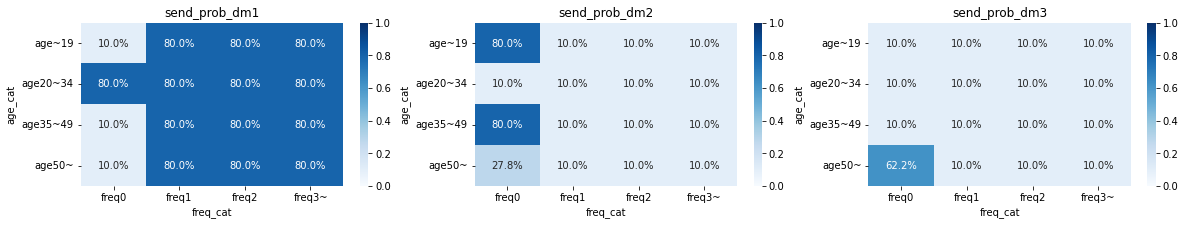

In [73]:
# ヒートマップ：各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize = (20, 3))
for i, ptn in enumerate(["send_prob_dm1", "send_prob_dm2", "send_prob_dm3"]):
  seg_send_pivot_df = pd.pivot_table(data = seg_send_df, values = ptn, columns = "freq_cat", index = "age_cat", aggfunc = "mean")
  seg_send_pivot_df = seg_send_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
  sns.heatmap(seg_send_pivot_df, annot = True, fmt = ".1%", cmap = "Blues", vmin = 0, vmax = 1, ax = ax[i])
  ax[i].set_title(f"{ptn}")
plt.show()

In [81]:
# 各セグメントに対するそれぞれのダイレクトメール送付数
seg_send_df["num_cust"] = seg_send_df["segment_id"].apply(lambda x: Ns[x])
seg_send_df["send_num_dm1"] = seg_send_df["num_cust"] * seg_send_df["send_prob_dm1"]
seg_send_df["send_num_dm2"] = seg_send_df["num_cust"] * seg_send_df["send_prob_dm2"]
seg_send_df["send_num_dm3"] = seg_send_df["num_cust"] * seg_send_df["send_prob_dm3"]
seg_send_df

,segment_id,age_cat,freq_cat,send_prob_dm1,send_prob_dm2,send_prob_dm3,num_cust,send_num_dm1,send_num_dm2,send_num_dm3
0,1,age~19,freq0,0.1,0.800000,0.100000,200,20.0,160.000000,20.000000
1,2,age~19,freq1,0.8,0.100000,0.100000,150,120.0,15.000000,15.000000
2,3,age~19,freq2,0.8,0.100000,0.100000,50,40.0,5.000000,5.000000
3,4,age~19,freq3~,0.8,0.100000,0.100000,100,80.0,10.000000,10.000000
4,5,age20~34,freq0,0.8,0.100000,0.100000,600,480.0,60.000000,60.000000
5,6,age20~34,freq1,0.8,0.100000,0.100000,450,360.0,45.000000,45.000000
6,7,age20~34,freq2,0.8,0.100000,0.100000,150,120.0,15.000000,15.000000
7,8,age20~34,freq3~,0.8,0.100000,0.100000,300,240.0,30.000000,30.000000
8,9,age35~49,freq0,0.1,0.800000,0.100000,800,80.0,640.000000,80.000000
9,10,age35~49,freq1,0.8,0.100000,0.100000,600,480.0,60.000000,60.000000


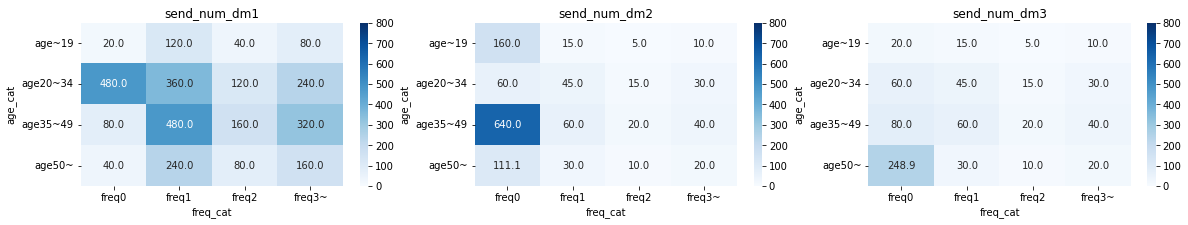

In [84]:
# ヒートマップ：各セグメントに対するそれぞれのダイレクトメールの送付率
ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize = (20, 3))
for i, ptn in enumerate(["send_num_dm1", "send_num_dm2", "send_num_dm3"]):
  seg_send_pivot_df = pd.pivot_table(data = seg_send_df, values = ptn, columns = "freq_cat", index = "age_cat", aggfunc = "mean")
  seg_send_pivot_df = seg_send_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
  sns.heatmap(seg_send_pivot_df, annot = True, fmt = ".1f", cmap = "Blues", vmin = 0, vmax = 800, ax = ax[i])
  ax[i].set_title(f"{ptn}")
plt.show()

# 4.5 結果の評価

## モデリング３：送付率下限値最大化モデル

In [85]:
# インスタンス生成
problem = pulp.LpProblem(name = "DiscountCouponProblem3", sense = pulp.LpMaximize)

In [87]:
# 要件１：
# (a) 各セグメントへのそれぞれのパターンのダイレクトメールの送付率の下限値と
# (b) 各セグメントに対してそれぞれのパターンのダイレクトメールをどの程度送付するかを決定

# (a)
y = pulp.LpVariable(name = "y", lowBound = 0, upBound = 1, cat = "Continuous")

# (b)
xsm = {}
for s in S:
  for m in M:
    xsm[s, m] = pulp.LpVariable(name = f"xsm({s}, {m})", lowBound = 0, upBound = 1, cat = "Continuous")

In [88]:
# 要件３：各セグメントへのそれぞれのパターンのダイレクトメールの送付率の下限値を最大化
problem += y

In [89]:
# 要件５：各パターンのダイレクトメールを設定した送付率の下限値以上送付
for s in S:
  for m in M:
    problem += xsm[s, m] >= y

In [90]:
# 要件２＆４（前節同様）

# 要件２：各会員に対して送付するダイレクトメールはいずれか１パターン
for s in S:
  problem += pulp.lpSum( xsm[s, m] for m in M ) == 1

# 要件４：会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum( Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3] ) <= 1000000

In [91]:
# 問題を解く
status = problem.solve()
max_lowerbound = pulp.value(problem.objective)
print(f"ステータス：{pulp.LpStatus[status]}, 目的関数値：{max_lowerbound:.3}")

ステータス：Optimal, 目的関数値：0.131


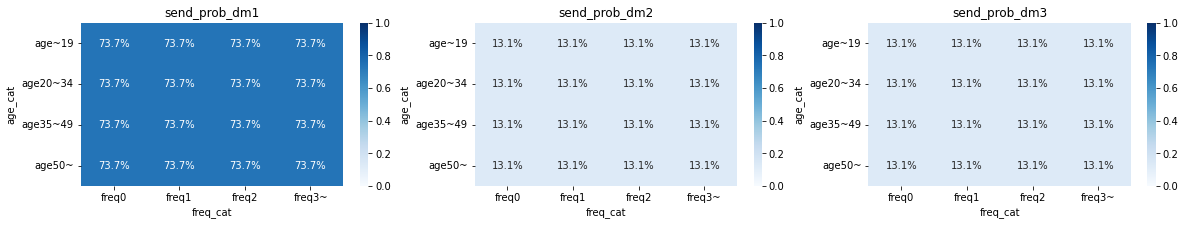

In [92]:
# ヒートマップ：各セグメントへの送付率
send_dm_df = pd.DataFrame([ [xsm[s, m].value() for m in M] for s in S ], columns = ["send_prob_dm1", "send_prob_dm2", "send_prob_dm3"])
seg_send_df = pd.concat( [prob_df[["segment_id", "age_cat", "freq_cat"]], send_dm_df], axis = 1 )

ax = {}
fig, (ax[0], ax[1], ax[2]) = plt.subplots(1, 3, figsize = (20, 3))
for i, ptn in enumerate(["send_prob_dm1", "send_prob_dm2", "send_prob_dm3"]):
  seg_send_pivot_df = pd.pivot_table(data = seg_send_df, values = ptn, columns = "freq_cat", index = "age_cat", aggfunc = "mean")
  seg_send_pivot_df = seg_send_pivot_df.reindex(["age~19", "age20~34", "age35~49", "age50~"])
  sns.heatmap(seg_send_pivot_df, annot = True, fmt = ".1%", cmap = "Blues", vmin = 0, vmax = 1, ax = ax[i])
  ax[i].set_title(f"{ptn}")
plt.show()

### 送付率の下限値を変更したときの来客増加数

In [96]:
# インスタンス生成
problem = pulp.LpProblem(name = "DiscountCouponProblem4", sense = pulp.LpMaximize)

# 要件１：各セグメントに対してそれぞれのパターンのダイレクトメールをどの程度送付するかを決定
xsm = {}
for s in S:
  for m in M:
    xsm[s, m] = pulp.LpVariable(name = f"xsm({s}, {m})", lowBound = 0, upBound = 1, cat = "Continuous")

# 要件２：各会員に対して送付するダイレクトメールはいずれか１パターン
for s in S:
  problem += pulp.lpSum( xsm[s, m] for m in M ) == 1

# 要件３：クーポン付与による来客増加数を最大化
problem += pulp.lpSum( Ns[s] * (Psm[s, m] - Psm[s, 1]) * xsm[s, m] for s in S for m in [2, 3] )

# 要件４：会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum( Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3] ) <= 1000000

# 要件５：各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上送付
for s in S:
  for m in M:
    problem += xsm[s, m] >= max_lowerbound

# 問題を解く
status = problem.solve()
print(f"ステータス：{pulp.LpStatus[status]}, 目的関数値：{pulp.value(problem.objective):.4}")

ステータス：Optimal, 目的関数値：300.6


## 投資対効果の評価

### 送付率の下限を10%とした場合のキャンペーン予算の最小値

In [98]:
# インスタンス生成
problem = pulp.LpProblem(name = "DiscountCouponProblem5", sense = pulp.LpMinimize)

# 要件１：

# (a) 各セグメントに対してそれぞれのパターンのダイレクトメールをどの程度送付するかを決定
xsm = {}
for s in S:
  for m in M:
    xsm[s, m] = pulp.LpVariable(name = f"xsm({s}, {m})", lowBound = 0, upBound = 1, cat = "Continuous")

# (b) キャンペーン予算
y = pulp.LpVariable(name = "y", lowBound = 0, cat = "Continuous")

# 要件２：各会員に対して送付するダイレクトメールはいずれか１パターン
for s in S:
  problem += pulp.lpSum( xsm[s, m] for m in M ) == 1

# 要件３：キャンペーン予算を最小化
problem += y

# 要件４：会員の予算消費期待値の合計は100万円以下
problem += pulp.lpSum( Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3] ) <= y

# 要件５：各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上送付
for s in S:
  for m in M:
    problem += xsm[s, m] >= 0.1

# 問題を解く
status = problem.solve()
print(f"ステータス：{pulp.LpStatus[status]}, 目的関数値：{pulp.value(problem.objective)}")

ステータス：Optimal, 目的関数値：761850.0


### キャンペーン予算を変化させたときの来店数１人あたりの獲得費用（CPA）の変化

In [99]:
# キャンペーン費用のリスト
cost_list = []

# CPAのリスト
cpa_list = []

# 来客増加数のリスト
inc_action_list = []

In [100]:
# 実装
print("ステータス，キャンペーン費用，来客増加数，CPA")

# キャンペーン予算を変化させて，繰り返し問題を解く
for cost in range(761850, 3000000, 100000):

  # インスタンス生成
  problem = pulp.LpProblem(name = "DiscountCouponProblem6", sense = pulp.LpMaximize)

  # 要件１：各セグメントに対してそれぞれのパターンのダイレクトメールをどの程度送付するかを決定
  xsm = {}
  for s in S:
    for m in M:
      xsm[s, m] = pulp.LpVariable(name = f"xsm({s}, {m})", lowBound = 0, upBound = 1, cat = "Continuous")

  # 要件２：各会員に対して送付するダイレクトメールはいずれか１パターン
  for s in S:
    problem += pulp.lpSum( xsm[s, m] for m in M ) == 1

  # 要件３：クーポン付与による来客増加数を最大化
  problem += pulp.lpSum( Ns[s] * (Psm[s, m] - Psm[s, 1]) * xsm[s, m] for s in S for m in [2, 3] )

  # 要件４：会員の予算消費期待値の合計は100万円以下
  problem += pulp.lpSum( Cm[m] * Ns[s] * Psm[s, m] * xsm[s, m] for s in S for m in [2, 3] ) <= cost

  # 要件５：各パターンのダイレクトメールをそれぞれのセグメントに属する会員数の10%以上送付
  for s in S:
    for m in M:
      problem += xsm[s, m] >= 0.1

  # 問題を解く
  status = problem.solve()
  cpa = cost / pulp.value(problem.objective)
  inc_action = pulp.value(problem.objective)
  
  # リスト更新
  cost_list.append(cost)
  cpa_list.append(cpa)
  inc_action_list.append(inc_action)

  # 結果表示
  print(f"{pulp.LpStatus[status]}, {cost}, {inc_action:.4}, {cpa:.5}")

ステータス，キャンペーン費用，来客増加数，CPA
Optimal, 761850, 229.0, 3326.9
Optimal, 861850, 273.1, 3156.3
Optimal, 961850, 311.9, 3084.0
Optimal, 1061850, 349.1, 3042.0
Optimal, 1161850, 385.8, 3011.8
Optimal, 1261850, 422.3, 2988.0
Optimal, 1361850, 458.8, 2968.0
Optimal, 1461850, 495.2, 2951.8
Optimal, 1561850, 530.5, 2944.2
Optimal, 1661850, 565.6, 2938.4
Optimal, 1761850, 600.7, 2933.2
Optimal, 1861850, 634.2, 2935.9
Optimal, 1961850, 667.3, 2940.2
Optimal, 2061850, 700.2, 2944.5
Optimal, 2161850, 732.5, 2951.4
Optimal, 2261850, 764.1, 2960.1
Optimal, 2361850, 795.5, 2969.2
Optimal, 2461850, 826.8, 2977.5
Optimal, 2561850, 858.1, 2985.3
Optimal, 2661850, 889.5, 2992.6
Optimal, 2761850, 920.8, 2999.3
Optimal, 2861850, 951.7, 3007.1
Optimal, 2961850, 981.9, 3016.4


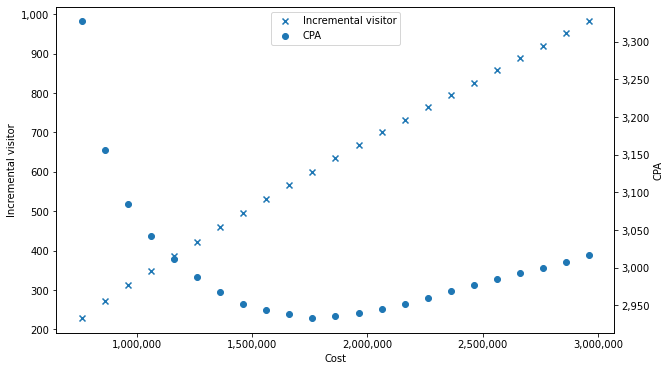

In [123]:
# キャンペーン費用とCPA，来客増加数を可視化
import matplotlib.ticker as ticker
fig, ax1 = plt.subplots(figsize = (10, 6))
ax2 = ax1.twinx()

# 来客増加数
ax1.scatter(cost_list, inc_action_list, marker = "x", label = "Incremental visitor")
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax1.set_xlabel("Cost")
ax1.set_ylabel("Incremental visitor")

# CPA
ax2.scatter(cost_list, cpa_list, label = "CPA")
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f"{x:,.0f}"))
ax2.set_ylabel("CPA")

# legend
reg1, label1 = ax1.get_legend_handles_labels()
reg2, label2 = ax2.get_legend_handles_labels()
ax2.legend(reg1 + reg2, label1 + label2, loc = "upper center")